### Bonferroni's Principle

Suppose you have a certain amount of data, and you look for events of a certain type within that data. You can expect events of this type to occur, even if the data is completely random, and the number of occurrences of these events will grow as the size of the data grows. These occurrences are “bogus,” in the sense that they have no cause other than that random data will always have some number of unusual features that look significant but aren’t.


A theorem of statistics, known as the **Bonferroni correction** gives a statistically sound way to avoid most of these bogus positive responses to a search through the data. Without going into the statistical details, we offer an informal version, Bonferroni’s principle, that helps us avoid treating random occurrences as if they were real.

### Large Scale File System organization

This new file system is called distributed file system (DFS) and is used for:
    
    - Enormous files, possibly in terrabyte in size. For, small files have no point to use DFS 
    - Files are rarely updated. They are used to read data or appending additional data.
    

Files are divided into chunks (typically 64 MB). Chunks are replicated (~3 times) on different compute nodes (should be different racks). To find the chunk of file, there is another small file master node or name node for that file. Master node is itself replicated.


**Chunk Servers**
1. When a map reduce job is started, chunks are distributed among different worker nodes/ chunk servers with some replication factor
2. Each chunk server can have multiple chunks of data, with each chunk having its own mapper.

### Map Reduce

* Manages large scale computations in a way that is tolerant of hardware faults.
* 2 Functions, Map and Reduce, while system manages the parallel execution.

**Steps for map-reduce computation**
1. Some number of Map tasks each are given one or more chunks from a distributed file system. These map tasks turns the chunk into a sequence of key-value pairs.
2. Key-Value pairs from each map task are collected by a master controller and sorted by key. The key are divided among all the reduce tasks. All key-value pairs with same key wind up at same Reduce task.
3. The Reduce tasks work on one key at a time and combine all the values associated with the key in some way.


* **Map Task**
* **Grouping and Aggregation**
* **Reduce Task**
        
**Coping with Failures**
1. If node at with Master is executing fails, then the entire map-reduce job must be restarted. This is the worst case, other failures will be managed by the Master, and map-reduce job will complete eventually.
2. Suppose if Map worker fails. The fail will be detected by Master because it periodically pings the Workers. All map task assigned to this worker will have to redone even if it is completed. Becuase output is destined to Reduce tasks, and now unavailable to reduce tasks. The master must also inform reduce tasks that the location of input from map task has changed.
3. Dealing with failure at the node of Reduce worker is simpler. The Master simply sets the status of its currently executing Reduce tasks to idle. These will be rescheduled on another reduce worker later.

### Data Flow
1. Input and output data is stored on DFS. Scheduler tries to map tasks "close" to physical storage (chunk servers) of input data.
2. Intermediate results are stored on local FS of Map and reduce workers
3. Output is often input to another MapReduce task.

### Coordination : Master
1. Check status of task (idle, in-progress, completed)
2. idle - no worker assigned, gets scheduled as worker become available
3. When map tasks completes, it sends the master the location/sizes of intermediate files, one for each reducer.
4. Master pings workers periodically to detect failures.

**Task Granularity :** Measures amount of work which is performed by task.

**Fine Granularity tasks :** Finer grains -> more parallelism -> speedup. Minimizes time for fault recovery, pipeline shuffling, better load balancing.

**Refinement (Backup tasks) :** Slow worker -> increases job completion time. **Solution** is to keep backup copies of tasks. Whichever finishes first "wins". **Effect** Dramatically shortens job completion time.

**Refinement (Combiners) :** It is common for reduce function to be associate and commulative. So, it is possible to push some of what reduce does to Map tasks. Example instead of emitting (w,1) we could apply reduce function within the Map tasks, before it is subjected to grouping.

**Refinement (partition) :** Controlling how keys get partitioned, override the default partition function. Reducer need to ensure that record with same intermediate key end up at the same worker.

### Algorithms using Map-Reduce

Map-Reduce is not a solution to every problem, not even every problem that profitable can use many compute nodes operating in parellel.

1. **Matrix-Vector Multiplication**
   We have Matrix M (n x n) where $m_{ij}$ denote element at row i and column j. We also have a vector v of length n, jth element is $v_j$. Element $x_i$ is given by.
$$ x_i = \sum_{j=1}^n m_{ij}v_j $$
    * The matrix will be stored in DFS in the form of triples (i,j, $m_{ij}$).
    * *Map Function*: Each Map task will take entire vector v and a chunk of matrix M, to produce a key value pair. (i, $m_{ij}v_j$).
    * *Reduce Function*: A reduce task has simply to sum all values associated with a given key i. The result will be pair (i,$x_i$).

2. **Computing Selections**
    Do not need full power of map-reduce. Can be done in map portion alone.
    * *Map Function*: For each tuple t in R test if it satisfies C. If so, produce the key-value pair (t,t).
    * *Reduce Function*: Simply passes each key-value pair to the output.

3. **Computing Projections**
    Similar to selection, because may cause duplicates, reduce function must eliminate duplicates.
    * *Map Function*: For each tuple t in R, construct t'. Output the key-value pair (t', t').
    * *Reduce Function*: For each key t' just output one t'.


4. **Union**
    * *Map Function*: Turn each input tuple t into a key-value pair (t,t).
    * *Reduce Function*: Associated with each key t there will be either one/two values. Produce output (t,t) in either case.


5. **Intersection**:
    * *Map Function*: Turn each tuple t into a key-value pair (t,t).
    * *Reduce Function*: If key t has value list [t,t], then produce (t,t). Other wise produce (t, NULL)


6. **Difference**:
    * *Map Function*: For a tuple t in R, produce key-value pair (t,R) or (t,S).
    * *Reduce Function*: If assoicated value list is [R], then produce (t,t). else produce (t,NULL).

7. **Natural Join**
    * *Map Function*: For each tuple (a,b) of R, produce (b, (R,a)) as key-value pair. Similarly for S.
    * *Reduce Function*: Each key value b will be associated with a list of pairs that are either of the form (R,a) or (S,c). The outptut will be (b, (a,b,c)).
    
8. **Two Phase Map Reduce Matrix Multiply**
    * *1st Map Function*

     $$ A[ij] = emit( j, (A, i, A[ij]) ) $$ $$ B[jk] = emit( j, (B, k, B[jk] ) ) $$
    
    * *1st Reduce Function*
     
     For each (i,k) from A and B i.e (A, i, A[ij]) and (B, k, B[jk])
    
     $$ emit( (i,k), A[ij]*B[jk] ) $$
     
    * *2nd Map Function*
     
     pass through, does nothing
     $$ emit( k,v ) $$
     
    * *2nd Reduce Function*
     
     $$ emit( (i,k), sum(values) ) $$

# Market Basket Model

* Goal : Identify items that are brought together by **sufficiently many customers**
* Each basket is a small subset of items.
* I/o : List of baskets
* O/p : Association Rules Discovered (One Way)
* General many-many mappings between items(not baskets)
* Focuses on COMMON EVENTS (not rare ones)

### Support
* Support for Itemset I : Number of baskets containing all items in I (%)
* If support > support threshold: Itemset i is frequent itemset

        Conf(I -> j) = Support(I U j) / Support(I)

* Interesting Association Rules

        Not all high confidence rules are interesting

        Interest(I->j) = | Conf(I->j) - Pr[j] |
        
High positive or negative interest means presence of I encourages/discourages presence of j


**Association rules which have support >= s and confidence >= c will be frequent!**

### Computational Model

* MB Data kept in flat files on disk (not in db)
* True cost of mining is number of disk I/O.
* Association Rules read  data in passes which is used as cost measure
* Main Memory Bottleneck : Counting the pairs

**Naive Approach :** Number of pairs ina basket = nC2 = n!/r! (n-r)!
(Requires too much main memory)

> Approach 1:
* Triangular Matrix : 
        
        Pair Count at position (i,j) = (i-1)(n-i/2) + j - i
        Every time you see a pair (i,j) from basket, increment counter at that position.
        4 bytes / pair

> Approach 2:
        
        Pair are stored as tuple (i, j, count), for each pair 12 bytes will be required.
        
> Triangular matrix will be better if at least 1/3 of the nC2 possible pairs actually appear in some basket


### Apriori Algorithm
> 2 pass approach : 
        
        Pass 1 - Identifies frequent itemsets of size 1
        Pass 2 - Identifies frequent itemsets of size 2 for pairs frequent in pass 1

> Limits need of main memory

> Monotonicity : If set of items I appears s tines, so does every subset J of I

> Contrapositive for Pairs : If item i doesn't appear in s baskets, no pair including i can appear in s baskets.



### Park-Chen-Yu Algorithm

1. During Pass 1 of A-priori, most memory is idle.
2. Use that memory to keep counts of buckets into which pairs of items are hashed.
3. For each bucket just keep the count, not the actual pairs that were used to create that bucket.
4. 

        For each basket
            for each item in basket
                add 1 to item's count
            
            #PCY
            for each pair of item
                hash the pair to a bucket
                add 1 to count for that bucket
                
5. Pairs of items need to be generated from input file, they are not present in file
6. A bucker is frequent if its count is at least the support threshold s.
7. If a bucket contains a frequent pair then the bucket is surely frqueunt.
8. However even without a frequent pair, a bucket  can be still be frquent. (So we cant use hash to eliminate any member of a frequent bucket.)
9. But for abucket with total count less that s, none of its pairs can be frequent. (pairs that hash to this bucket can be eliminated as candidates)

**Between Passes**
1. Replace the buckets by a bit-vector. 1 meaning bucket count exceeded the support s (frequent bucket)
2. 4 bytes (32 bits) integer counts are replaced by bits, so the bit-vector requires 1/32 of memory.

**Pass 2**:
1. Count all pairs {i,j} that meet condition for being a candidate pair:
    
       Both i and j are frequeunt items.
       The pairs {i,j} hashes to a bucket whose bit in the bit vector is 1 (frquent bucket)
       
       Both conditions are necessary for the pair to have a chance of being frequent.
       



1. Cannot use triangular matrix approach because pairs in infrequent buckets are spread randomly.
2. To use PCY, hash table must eliminate approx 2/3 of the candidates pairs for PCY to beat A-priori.


**Refinement: Multistage Algorithm**
1. Limit the numbers of candidates to be counted.
2. Still need to generate all itemssets but we only want to count/keep track of the ones that are frequent.
3. **Key idea**: After Pass 1 of PCY, rehash only those pairs that qualify for pass 2 of PCY.
4. 

        Pass 1: Count items Hash pairs {i,j}
        Pass 2: Hash pairs {i,j} into Hash2 iff:
            i,j are frequent, {i,j} hashes to be freq in bucket B1.
        Pass 3: Count pairs {i,j} iff i,j are frequeny {i,j} hashes to freq. bucket in B2 {i,j} hashes to freq. bucket in B2.
        
        
**Refinement: Multihash**
1. **Key Idea** : Use several independent hash tables on the first pass.
2. **Risk**: Having number of buckets doubles the average count. 
        
        We have to be sure most buckets will still not reach count s.
        
3. If so, we can get a benefit like multistage, but in only 2 passes.

4. In second pass, it will be same as multistage, Count only those pairs {i,j} that satisfy these candidates pair condition:
    
       - Both i and j are frequent items
       - Using 1st hash function, the pair hashes to a bucket whose bit-vector is 1
       - Using 2nd hash function the pair hashes to a bucket whose bit in the second bit-vector is 1.
       
**PCY extensions**
1. In multistage, there is a point of diminishing return, since bit-vectors eventually consume all main memory.
2. For multihash, the bit-vectors occupy exactly what one PCY bitmap does, but too many hash functions makes all count >= s.

### Limited Pass Algorithm

* So far, compute exact collection of frequent itemsets of size k in k passes. (A-priori, PCY, Multistage, Multihash)

* In Many applications it is not essential to discover every frequent itemset, it is sufficient to discover most of them.

* Algorithms that find all or most frequent itemsets using at most 2 passes over data

    - Sampling
    - SON
    - Toivonen's Algorithm

### Random Sampling

1. Take a random sample of the market baskets that fits in the main memory. (Leave enough space in memory for counts)
2. Run a-priori or one of its improvement in main memory.
    - For sets of all sizes, not just pairs
    - Don't pay for disk I/O each time we increase the size of itemsets
    - Reduce support threshold proportionally to match the sample size.
3. In Random Sampling we cannot guarantee:
    - Algorithm will produce all itemsets that are frequent in whole dataset. (False negative)
    - Produce only itemsets that are frequent in whole datasets (False positive)
4. Avoid Errors
    - Eliminate False positives: Count/validate them in entire dataset once found.
    - Reduce False negative: Reduce the threshold like e.g. 0.9ps

### Savasere, Omiecinski and Navathe (SON) algorithm

1. Avoids false negative and false positives.
2. Requires two full passes over data.
3. 1st Pass

       Repeatedly read small subsets of the baskets into main memory. (it is not sampling, we will process entire file in memory-sized chunks)
       Run an in-memory algorithm (eg. a priori, random sampling, PCY) to find all frequent itemsets.
       An itemset becomes a candidate if it is found to be frequent in any one or more subsets of the baskets.
       
4. 2nd Pass
    
       Count all the candidate itemsets and determine which are frequent in the entire set.
       
       Key "monotonicity" idea: an itemset cannot be frequent in the entire set of baskets unless it is frequent in at least one subset.
       
5. Distributed Version:
    
* SON lends iteself to distributed data mining (Map Reduce)
* Baskets distibuted among many nodes
    - Subsets of data may correspond to one or more chunks in DFS.
    - Compute frequent itemsets at each node.
    - Distribute candidates to all nodes
    - Accumulate the count of all candidates
* **Phase 1**: Find candidate itemset
    - Map:
            
            * Input is a chunk/subset of all baskets; fraction p of total input file.
            * Find itemsets frequent in that subset (eg. use Random Sampling algo)
            * Use support threshold ps
            * Output is set of key-value pairs (F,1) where F is frequent itemsets from sample.
    
    - Reduce:
    
            * Each reduce task is assigned set of keys, which are itemsets
            * Produce keys that appear one or more time.
            * Frequent in some subset
            * These are candiate itemsets.
    
* **Phase 2**: Find true frequent itemsets
    - Map
    
            * Each Map task takes output from 1st Reduce task AND a chunk of total input data file.
            * All candidate itemsets go to every Map task.
            * Count occurences of each candidate itemsets amoung the baskets in input chunk.
            * Output is set of key-value pair (C,v) where C is candidate frequent itemsets and v is support for that itemset among the baskets in the input chunk.
            
    - Reduce
    
            *  Each reduce tasks is assigned a set of keys (itemsets)
            * Sums associated values for each key: total support for itemset
            * If support of itemset >= s, emit itemset and its count.

### Toivonen's Algorithm

    * Another Approximation algorithm
    * Given sufficient main memory, uses one pass over a small sample and one full pass over data.
    * Gives no false positives or false negatives.
    * But there is small but finite probability it will fail to produce an answer (Will not identify frquent itemsets)
    * If fails must be repeated with different sample untill gives an answer.

> First find candidates frequent itemsets from sample
    - Start as in random sampling algorithm, but lower the threshold slightly for the sample. (0.8ps)
    - Goal is to avoid missing any itemset that is frequent in the full set of baskets.
    - The smaller the threshold: The more memory is needed to count all candidates itemsets, less likely the algorithm will not find an answer. 

* After finding frequent itemsets for the sample, construct  the negative border.
    
    * Negative Border: Collection of itemsets that are not frequent in the sample but all of their immediate subsets are frequent.
    * Immediate subset is constructed by deleting exactly one item.
    * Example: ABCD is neagtive border if and only if
        1. It is not frequent in sample, but
        2. All of ABC, BCD, ACD and ABD are frequent

* **First Pass**
    * first find candidate frequent itemsets from sample
    * Identify itemsets that are frequent for the sample
    * Construct the negative border.
    * Itemsets that are not frequent in the sample but all their immediate subsets are frequent.

* **Second Pass**
    * In second pass, process the whole file (no sampling)
    * Count all candiate frequent itemset from first pass and for all itemsets on the negative border
    
* **Case 1:** No itemset from negative border turns out to be frequent in the whole data set. (Correct set of frequent itemsets is exactly the itemsets from the sample that were found frequent in the whole data)

* **Case 2:** Some member of negative border is frequent in the whole dataset. Can give no answer at this time. Must repeat the algorithm with new random sample.

# Finding Similar Items

### Jaccard Similarity

**Jaccard Similarity** = Intersection over union 

**Jaccard Distance** = 1- Jaccard Similarity


**Buyer to Item** : Buyer and set of item they have purchased. Similiarity between buyers for buyer to item recommendation.

**Item to Buyer** : Item and set of buyers who have purchased that item. Similarity between items for item to item recommendation.

**Problem with Apriori Here**: A large number of items but B1 and B2 only appears in 2 baskets and hence very low support, but they are still similar.


### Steps to find similar documents

1. Shingling : Convert docs to sets
2. Min-Hashing : Convert large sets to short signatues while preserving simialrity
3. Local Senisitve Hashing : Focus on paris of signature likely to be from similar docs.

**Shingles:**

* A k-Shingle (k-gram) for a document is a sequence of k-tokens that appear in the doc. Tokens can be word, chars, or anything else. 

* Shingles can be as a bag (multiset) count element twice. eg. S(abcab) = { ab, bc, ca, ab }

* (N-k+1) ~ n shingles for a page of n characters?

* If k is too small then many document will falsely become similar.

* Too big k, mightly miss truly similar documents.

* k=5, OK for short docs (email, tweet)....k = 10, better for long docs

* Compressing Shingles: To compress we can hash them to 4bytes(int) called tokens

* we can differentiate documents better if we use 9-shingles and hash them down to four bytes than to use 4-shingles, even though the space used to represent a shingle is the same.

* Each document is a vector of 0s, 1s in the space of k-shingles. Each unique shingle is a dimension. Vectors are very sparse. 

* We will use Jaccard similarity to calculate similarity between docs.

**MinHashing**

* Suppose we have to find near-duplicate docs among million docs, We will have to make $5*10^{11}$ compairsison. Very expensive!!!

* Minhashing: Convert large set to short signature while preserving similarity.

* From Set to boolean matrices, each columns is a document and rows are elements of universal set. Column similarity is Jaccard similarity of the sets of their rows with 1 intersection/union of sets.

* typically matrix is sparse so usually represented by list of non-zero values (eg. triples)

* Comparing signature can produce false negatives and even false positive (if the optional check - comparing cols is not made.)

* "hash" each column C to a small signature Sig(C). Sig(C) is small enough that we can fit a signature in memory for a each column. Sim(C1, C2) is the same as "similarity" of Sig(C1) and Sig(C2)

* To minhash a set represented by a column of matrix, pick a random permutation of the rows. "hash" function. h(C) = the number of the first row (in permuted order) in which column C has 1.

* The probability that the minhash function for a random permutation of rows produces the same value for 2 sets equals jaccard similarity of those sets.
    
        1. Type X rows have 1 in both column
        2. Type Y rows have 1 in one of the column and 0 in other.
        3. Type Z rows have 0 in both columns
        
        Since matrix is sparse most rows are of type Z. Let x be the rows of type X and y be the rows of type Y. SIM(S1,S2) = x/(x+y)
        
        If h(S1) = h(S2). Imagine the rows permutated randomly, the probability that we shall meet type X row before we meet type Y is x/(x+y). If first row is of type X (except Z rows), then surely h(S1)=h(S2).
        
        On the other hand, if first row is of type Y (except Z rows). then set with 1 get the row as its minhash value. The set with 0 will get some row further down the permutated list. Thus we know h(S1) != h(S2).
        
         Conclusion probability that h(S1) = h(S2) is x/(x+y). Which is also the Jaccard similarity of S1 and S2.

* Use several (e.g., 100) independent hash functions to create a signature. Call the minhash functions determined by the permutations h1, h2, h3...hn. From Column representing set S, construct the minhash signature for S, the values [ h1(S), h2(S),....hn(S) ]. 

* Signature matrix has a same number of columns as M but only n rows.

* It is not possible to permute large matrix explicitly. However it is possible to simulate the effect of random permutation by random hash function that maps row numbers to as many buckets as there are rows. **A hash function that maps integers 0...k-1 to bucket numbers 0 through k-1 typically will map some pairs of integer to same bucket and leave some buckets unfullfilled.** However this difference is unimportant as long as k is large and there are not too many collisions. 
        
       Hash function h "permutes" row r to position h(r) in permuted order
       
* Instead of picking n random permutation we pick n randomly choosen hash functions h1, h2...hn on the rows. SIG(i,c) be the element of signature matrix for the ith hash function and column c. Initially set SIG(i,c) to infinity for i and c.

* 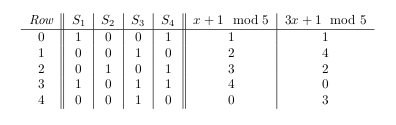



          S1    S2    S3     S4
      h1  inf   inf   inf    inf
      h2  inf   inf   inf    inf
      
      h1  1     inf   inf    1
      h2  1     inf   inf    1
      
      h1  1     inf    2     1
      h2  1     inf    4     1
      
      h1  1     3      2     1
      h2  1     2     inf    1
      
      h1  1     3      2     1
      h2  0     2      0     0
      
      h1  1     3      0     1
      h2  0     2      0     0

### Local Sensitive Hashing for Documents

* 